<a href="https://colab.research.google.com/github/ThaynaraMatias/biblioteca/blob/main/Face_Maks_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[0] Importação das Bibliotecas

In [ ]:
import numpy as np
from keras.models import Sequential #Sequência de modelos
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten, Dropout #Camadas
from keras.metrics import categorical_crossentropy #Função de custo
from keras.preprocessing.image import ImageDataGenerator #Pré-processamento de imagens
from keras.callbacks import ModelCheckpoint  # Para salvar o modelo
from sklearn.metrics import confusion_matrix # Matriz de confusão
from keras.utils.vis_utils import plot_model # Plotagem do modelo

import itertools
import os
import shutil
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] PRÉ-PROCESSAMENTO DE DADOS DE IMAGEM
DataSet: https://www.kaggle.com/ahemateja19bec1025/facemask-dataset
*   Organizaremos nossos dados em conjuntos de treino, validação e teste.




In [ ]:
path_train = '/content/drive/MyDrive/Face_Mask_Detection/DataSet/treinamento'       #Treinamento
path_valid = '/content/drive/MyDrive/Face_Mask_Detection/DataSet/validacao'         #Validação
path_test = '/content/drive/MyDrive/Face_Mask_Detection/DataSet/teste'              #Teste

### **[1.1] Gerando o conjunto de dados de treino, validação e teste**


#### **[1.1.1] ImageDataGenerator**

In [ ]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_gen =  ImageDataGenerator(rescale = 1.0/255.0)

#### **[1.1.2] Flow_from_directory**

In [ ]:
train_batches = train_gen.flow_from_directory(directory = path_train, batch_size = 32 , color_mode= 'rgb' ,target_size=(200, 200), seed = 42, class_mode = 'binary')
valid_batches = valid_gen.flow_from_directory(directory = path_valid, batch_size = 32 , color_mode= 'rgb' ,target_size=(200, 200), seed = 42, class_mode = 'binary')
test_batches = test_gen.flow_from_directory(directory = path_test, batch_size = 32,  color_mode= 'rgb', target_size=(200, 200), seed = 42, class_mode = 'binary')

Found 1112 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


In [ ]:
# Vendo os rótulos e os dados gerados
train_batches.class_indices

{'com_mascara': 0, 'sem_mascara': 1}

### **[1.2] Verificando as imagens**


In [ ]:
# Pegando um único lote de imagens e as labels do train_batches
images , labels = next(train_batches) # Deve haver 32 imagens (Tamanho do batch)

In [ ]:
# Plotando as imagens do lote acima
# Esta função irá traçar imagens na forma de uma grade com 1 linha e 10 colunas onde as imagens são colocadas
def plotingImages(images_array):
    fig, axes = plt.subplots(4, 8, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off') # Desliga os eixos em torno de cada imagem

    plt.tight_layout()
    plt.show()

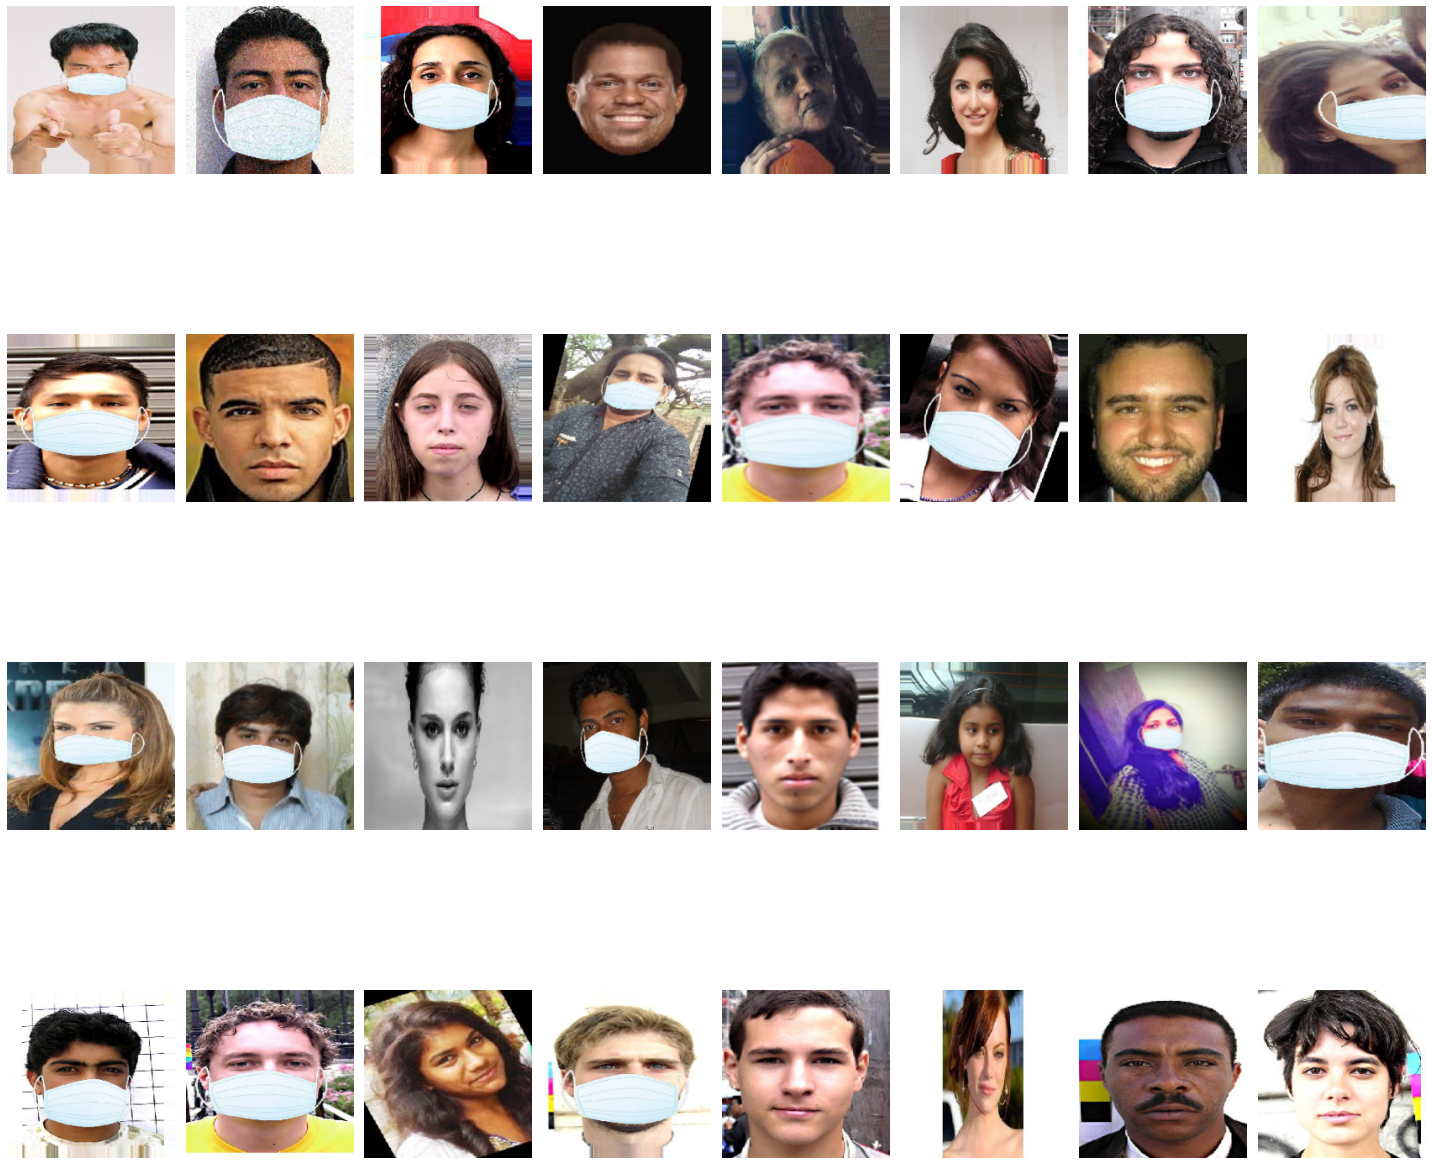

[0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 1.]


In [ ]:
plotingImages(images) # Visualizado apenas 64 imagens
print(labels)

## **[2] MODELO - REDE NEURAL CONVOLUCIONAL**


In [ ]:
images.shape # Os dados de treinamento são imagens de pessoas: 32 amostras, cada uma com 200 por 200 pixels, e com ultima dimensão de 3 canais devido ao RGB

(32, 200, 200, 3)

### **[2.1] Construindo o modelo**

In [ ]:
# Modelo como uma pilha simples de camadas onde cada camada tem exatamente um tensor de entrada e um tensor de saída .
model = Sequential()

In [ ]:
# A primeira camada está conectada a todos os pixels na imagem de entrada
model.add(Conv2D(filters = 200, kernel_size = (3, 3), activation = 'relu', input_shape=(200,200,3)))

In [ ]:
model.add(MaxPooling2D(pool_size=(2, 2)))

In [ ]:
model.add(Conv2D(filters = 100, kernel_size = (3, 3), activation = 'relu'))

In [ ]:
model.add(MaxPooling2D(pool_size=(2, 2)))

In [ ]:
model.add(Flatten())
model.add(Dropout(0.5)) # O dropout é uma técnica usada para evitar que um modelo seja superdimensionado

In [ ]:
# Redes densamente conectadas - Cada unidade em cada camada está conectada a todas unidades na camada anterior
  # Usaremos 50 unidades
  # Função de ativacao = relu
model.add(Dense(50, activation='relu'))

# Saida da rede é uma camada totalmente conectada com uma unidade para cada classe: 2 tipos
  # Usa a função de ativação softmax para decidir qual das duas classes foi apresentada
    # Nos dá a probabilidade para cada saída correspondente
model.add(Dense(2, activation='softmax'))

### **[2.2] Visualizando o modelo**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 200)     5600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 230400)            0         
                                                                 
 dropout (Dropout)           (None, 230400)            0

### **[2.3] Compilando o modelo**

In [ ]:
# Compilamos o modelo
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### **[2.4] Treinando o modelo**

- Durante o treinamento, a rede ajusta seus pesos por meio da retropopagação e descida do gradiente
- Podemos analisar os dados várias vezes até que a rede possa classificar as imagens com precisão
- O modelo será executado por 20 épocas, o que significa que examinará todos os dados de treinamento 20 vezes
- Em cada época, o programa acompanha o progresso no conjunto de dados (Loss function e accuracy)

### **[2.5] Validando o modelo**
- É de preocupação que o algoritmo possa se ajustar demais aos dados de treinamento. Ou seja, pesos resultam em um erro muito pequeno no conjunto de treinamento, mas não generalizam bem para outro conjunto de dados.

- Para evitar o ajuste excessivo, separamos um conjunto de imagens de validação

- No final de cada epoca de treinamento, testaremos o modelo neste conjunto de validação

- Abaixo foi usado o `valid_bacthes` das imagens para validação em `validation_data`

In [ ]:
# ModelCheckpoint - o retorno de chamada é usado em conjunto com o treinamento model.fit() para
# salvar um modelo ou pesos (em um arquivo de ponto de verificação) em algum intervalo, para que
# o modelo ou pesos possam ser carregados posteriormente para continuar o treinamento a partir do estado salvo.
model_save = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model/face-detector-model.h5', monitor = 'val_loss', verbose = 0, save_best_only=True, mode = 'auto')

In [ ]:
# Quando os dados são armazenados como um gerador, o próprio gerador contém os rótulos e não precisamos
# especificar separadamente
history = model.fit(x=train_batches, validation_data=valid_batches, epochs = 20, callbacks=[model_save],steps_per_epoch = len(train_batches))

Epoch 1/20
35/35 [==============================] - 471s 13s/step - loss: 1.1423 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
35/35 [==============================] - 402s 12s/step - loss: 0.6934 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
35/35 [==============================] - 385s 11s/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/20
35/35 [==============================] - 378s 11s/step - loss: 0.6916 - accuracy: 0.5090 - val_loss: 0.6384 - val_accuracy: 0.7652
Epoch 5/20
35/35 [==============================] - 393s 11s/step - loss: 0.6184 - accuracy: 0.6637 - val_loss: 0.4050 - val_accuracy: 0.8636
Epoch 6/20
35/35 [==============================] - 388s 11s/step - loss: 0.2396 - accuracy: 0.9164 - val_loss: 0.1926 - val_accuracy: 0.9470
Epoch 7/20
35/35 [==============================] - 384s 11s/step - loss: 0.1872 - accuracy: 0.9469 - val_loss: 0.1320 - val_accuracy: 0.9470
Epoch 

### **[2.6] Testando o modelo**

- Outra avaliação do modelo deve ser feita em um conjunto de testes separado que não foi usado durante o treinamento.
- Nós da uma avaliação realista e separada da qualidade do modelo
 - Perda
 - Precisão

In [ ]:
# Avaliação do test data
model.evaluate(test_batches)

5/5 [==============================] - 62s 15s/step - loss: 0.0567 - accuracy: 0.9697


[0.05666295811533928, 0.9696969985961914]

**Predição de uma imagem do dataset**

In [ ]:
from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/Face_Mask_Detection/DataSet/teste/com_mascara/0-with-mask.jpg', target_size = (200,200,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(f"Result: {result}")
if result[0][0]==1:
    prediction = 'mask'
else :
    prediction = 'unmask'
print(prediction)

Result: [[1. 0.]]
mask


### **[2.7] Analisando os dados**

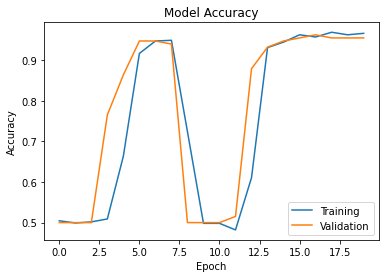

In [ ]:
# SUMÁRIO - HISTÓRICO DA ACURÁCIA
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('/content/drive/MyDrive/Face_Mask_Detection/DataSet/history_accuracy.png', format='png')
plt.show()

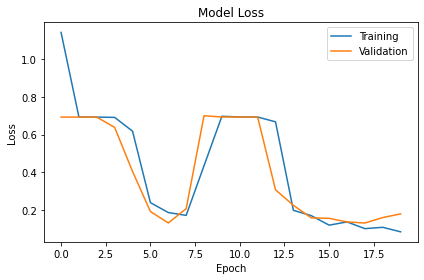

In [ ]:
# SUMÁRIO - HISTÓRICO DA FUNCAO DE CUSTO
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Face_Mask_Detection/DataSet/history_loss.png', format='png')
plt.tight_layout()

plt.show()